In [ ]:
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install matplotlib==3.3.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.3.4.tar.gz (37.9 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.3.4-cp310-cp310-linux_x86_64.whl size=11772915 sha256=8b8731dcb310c5e9ebf5876e36f1979d7116463ba0f6e6b129020e7dfdf35893
  Stored in directory: /root/.cache/pip/wheels/38/c6/49/eaba6d234887d98d9c85185e2a90bd7bb77934e85eefaf317e
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mizani 0.8.1 requires matplotlib>=3.5.0, but you have matplotlib 3.3.4 which is incompatible.
plotnine 0.10.1 requires matplotlib>=3.5.0, but you have matplot

In [ ]:
import torchvision
import torchvision.models as models

from torch.utils.data import Dataset
import torch
import torch.nn as nn

import pandas as pd
import os
import numpy as np
import PIL

import captum
from captum.attr import GuidedGradCam, IntegratedGradients, NoiseTunnel
from captum.attr import visualization as viz

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
!pip install torcheval
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/train.zip train.zip
!unzip train.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  train.zip
 extracting: train/annotations.xlsx  
 extracting: train/images/Image_0000_04_0_0_4.png  
 extracting: train/images/Image_0001_04_0_0_4.png  
 extracting: train/images/Image_0002_04_0_0_4.png  
 extracting: train/images/Image_0003_04_0_0_4.png  
 extracting: train/images/Image_0004_04_0_0_4.png  
 extracting: train/images/Image_0005_04_0_0_4.png  
 extracting: train/images/Image_0006_04_0_0_4.png  
 extracting: train/images/Image_0007_04_0_0_4.png  
 extracting: train/images/Image_0008_04_0_0_4.png  
 extracting: train/images/Image_0009_04_0_0_4.png  
 extracting: train/images/Image_0010_04_0_0_4.png  
 extracting: train/images/Image_0011_04_0_0_4.png  
 extracting: train/images/Image_0012_04_0_0_4.png  
 extracting: train/images/Image_0013_0

In [ ]:
import torchvision
import torcheval
import torchvision.models as models
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import pandas as pd
import os
import numpy as np
import PIL

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap



class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_excel(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
# TO BE FIXEDDD
    def __len__(self):
        #return len(self.img_labels)
        return 512

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image = PIL.Image.open(img_path).convert('RGB')
        #print(image.size)
        T1 = torchvision.transforms.Resize((250,250))
        T2 = torchvision.transforms.ToTensor()
        image = T1(image)
        #print(image.size)
        image = T2(image)
        # transform = torchvision.transforms.Compose([
        #     torchvision.transforms.Resize(256),
        #     torchvision.transforms.CenterCrop(224),
        #     torchvision.transforms.ToTensor(),
        #     # torchvision.transforms.ConvertImageDtype(torch.float),
        #     torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        #     ])
        # image = transform(image)
        #print(image.shape)
        image = image[:-1]
        assert(image.shape[0]==3)
        label = self.img_labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


suture_dataset = CustomImageDataset("train/annotations.xlsx","./train/images")
batch_size = 4
validation_split = .1
shuffle_dataset = True
random_seed= 42

dataset_size = len(suture_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(suture_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(suture_dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg = torchvision.models.vgg19(pretrained=True)
model_vgg.classifier[6] = nn.Linear(in_features=4096,out_features=1,bias=True)
model_vgg.requires_grad_(False)
for param in model_vgg.classifier[6].parameters():
  param.requires_grad=True
model_vgg.to(device)

optimizer = torch.optim.Adam(model_vgg.classifier[6].parameters(), lr=0.001)

from torcheval.metrics import R2Score

num_epochs=30
loss_fn = torch.nn.MSELoss()

val_loss_arr = []
train_loss_arr = []

val_R2_arr = []
train_R2_arr = []

R2metric = (R2Score()).to(device)

for epoch in range(num_epochs):
    # Train:
    running_loss = 0
    cnt = 0
    R2_train_loss = 0
    for batch_index, (images, labels) in enumerate(train_loader):
      cnt+=1
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      output = model_vgg(images).flatten()
      loss = loss_fn(output,labels.float())
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      R2metric.update(output,labels)
      R2_train_loss += R2metric.compute()

    epoch_loss = running_loss/cnt
    R2_train_loss /= cnt

    train_loss_arr.append(epoch_loss)
    train_R2_arr.append(R2_train_loss)
    

    # Validation:
    val_loss = 0
    R2_val_loss = 0
    #val_accuracy = 0
    cnt = 0
    cnt2=0
    for batch_index, (images,labels) in enumerate(validation_loader):
      cnt+=1
      images = images.to(device)
      labels = labels.to(device)
      with torch.no_grad():
        output = model_vgg(images).flatten()
        loss = loss_fn(output,labels.float())
        val_loss += loss.item()
        #pred = torch.round(output)
        #val_accuracy += torch.sum(pred==labels).item()
        #cnt2+= images.shape[0]
        R2metric.update(output,labels)
        R2_val_loss += R2metric.compute()
    
      
    #val_accuracy /= cnt2
    epoch_val_loss = val_loss/cnt
    R2_val_loss /= cnt

    val_loss_arr.append(epoch_val_loss)
    val_R2_arr.append(R2_val_loss)

    #print(f'epoch: {epoch} Train loss: {epoch_loss} Validation Loss: {epoch_val_loss} Validation Accuracy: {val_accuracy}')
    print(f'epoch: {epoch} Train loss: {epoch_loss} Validation Loss: {epoch_val_loss} R2_train_loss: {R2_train_loss} R2_val_loss: {R2_val_loss}')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch: 0 Train loss: 2.165980842510431 Validation Loss: 0.7667825915492498 R2_train_loss: -1.7521108388900757 R2_val_loss: -0.26369866728782654
epoch: 1 Train loss: 1.2679825743664346 Validation Loss: 0.8230875994150455 R2_train_loss: -0.07455224543809891 R2_val_loss: 0.0011972784996032715
epoch: 2 Train loss: 0.9367740551202461 Validation Loss: 0.9517658983285611 R2_train_loss: 0.07725633680820465 R2_val_loss: 0.1497087925672531
epoch: 3 Train loss: 0.8969331960001126 Validation Loss: 0.7689655618025706 R2_train_loss: 0.19618171453475952 R2_val_loss: 0.231079563498497
epoch: 4 Train loss: 0.9165405571332266 Validation Loss: 1.2782537134794087 R2_train_loss: 0.2590998411178589 R2_val_loss: 0.27193212509155273
epoch: 5 Train loss: 0.9990341763718632 Validation Loss: 1.0861923373662508 R2_train_loss: 0.28190457820892334 R2_val_loss: 0.28980135917663574
epoch: 6 Train loss: 0.9888459900072937 Validation Loss: 1.017322370639214 R2_train_loss: 0.3005296289920807 R2_val_loss: 0.3064353466033

In [ ]:
model = model_vgg.eval()

In [ ]:
# Get a few random images from the dataset
images, labels = next(iter(train_loader))

In [ ]:
images = images.to(device)
labels = labels.to(device)

In [ ]:
images[0].size()

torch.Size([3, 250, 250])

In [ ]:
image, label = images[3], labels[3]
image = image.unsqueeze(0)
integratedGradients = IntegratedGradients(model)
attributionsIg = integratedGradients.attribute(image, target=0, n_steps=50)

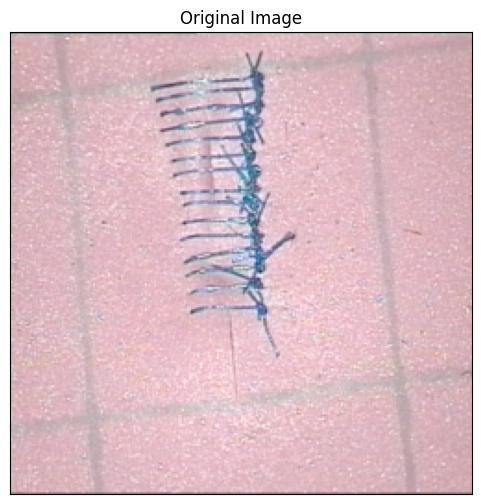

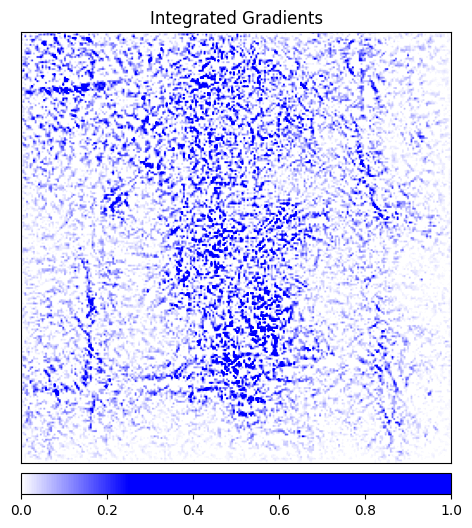

In [ ]:
_ = viz.visualize_image_attr(None, np.transpose(image.squeeze().cpu().detach().numpy(), (1,2,0)),
                      method="original_image", title="Original Image")

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributionsIg.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(image.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')